#Data

In [1]:
!gdown "1--2MHS70-Y8rZfsDd5PjztPevBC6Q5vd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1--2MHS70-Y8rZfsDd5PjztPevBC6Q5vd&confirm=t
To: /content/flickr8kimagescaptions.zip
100% 1.11G/1.11G [00:06<00:00, 170MB/s]


In [2]:
!unzip flickr8kimagescaptions.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

#Library

In [3]:
import os
import cv2
import tqdm
import torch 
import random
import torchtext
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from textwrap import wrap
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torchtext.data import get_tokenizer
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

#Visualize sample

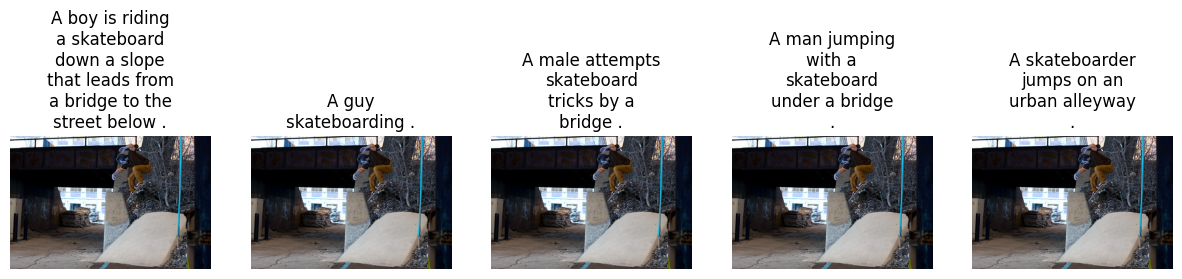

In [4]:
#Load captions
captions = open("/content/flickr8k/captions.txt")

captions = [line.strip().split(",") for line in captions]
dict_image_caption = {}

for i, item in enumerate(captions):
  if i==0:
    continue
  if item[0] in dict_image_caption.keys():
    dict_image_caption[item[0]].append(item[1])
  else:
    dict_image_caption[item[0]]= [item[1]]

keys = random.sample(list(dict_image_caption), 1)

for key in keys:
  img = cv2.imread(os.path.join("/content/flickr8k/images", key))
  plt.figure(figsize=(15, 15))
  for i,caption in enumerate(dict_image_caption[key]):
    ax = plt.subplot(1, len( dict_image_caption[key]), i + 1)
    caption = "\n".join(wrap(caption, 15))
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
  plt.show()

#Customize dataloader

In [5]:
# write dataloader 
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer("basic_english")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenToIndex = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
indexToToken = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
class MyDataset(Dataset):
  def __init__(self, img_dir, annotation_dir, transformer,threshold = 5):
    super(MyDataset, self).__init__()

    self.transformer = transformer;

    captions = open(annotation_dir)
    global tokenToIndex,indexToToken,stop_words,porter
    

    captions = [line.strip().split(",") for line in captions]
    captions = self.captions = captions[1:]
    # image name = captions[0]    image caption = captions[1]  
    frequencies = {}
    for caption in captions:
      tokens = tokenizer(caption[1])
      for token in tokens:
        token = porter.stem(token)
        if token in frequencies.keys():
          frequencies[token] += 1
        else:
          frequencies[token] = 1

    vocabCount = 4
    
    for token in frequencies.keys():
      if token.isalpha() and token not in stop_words:
        tokenToIndex[token] = vocabCount
        indexToToken[vocabCount] = token
        vocabCount += 1


      # if frequencies[token] >= threshold:
      #     tokenToIndex[token] = vocabCount
      #     indexToToken[vocabCount] = token
      #     vocabCount += 1
    print(vocabCount)
    self.vocabCount= vocabCount
    ############################################
    # your code here, you can add new parameter in constructor
    ############################################
  def __len__(self):
    return len(self.captions)
    ###########################################
    #your code here, you should be return size of vocabulary here
    ###########################################


  def stringfy(self, array):
    string = ""
    for item in array:
      if item in indexToToken.keys():
        string = string +' ' +indexToToken[item]
      else:
        string = string +' ' + '<UKN>'+item+' '
    return string
  def vocab_size(self):
    return self.vocabCount

  def __getitem__(self, index):
    imgs = Image.open("/content/flickr8k/images/" + self.captions[index][0]).convert('RGB')
    imgs = imgs.resize((64,64))    
    res = [1] #start of string
    for token in tokenizer(self.captions[index][1]):
      if token in tokenToIndex.keys():
        res.append(tokenToIndex[token])
    res.append(2) #end of string
    return self.transformer(imgs) , torch.tensor(
        res
    )
   ############################################
   #your code here, you should be retrun image and caption of that, please attention caption of image tokenized and cleaned
   ############################################   


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
dataset = MyDataset("/content/flickr8k/images", "/content/flickr8k/captions.txt",  transforms.Compose([
        transforms.ToTensor(),
    ]))

class BatchArrange:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = []
        for item in batch:
          imgs.append(item[0].unsqueeze(0))
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

####################################################
#your code here 
###################################################

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-200, 195,5])
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True,batch_size=5,collate_fn=BatchArrange(pad_idx=0))
val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size=5,collate_fn=BatchArrange(pad_idx=0))
test_loader = torch.utils.data.DataLoader(test_set,shuffle=True,batch_size=5,collate_fn=BatchArrange(pad_idx=0))

5488


#Model

In [7]:
class ImageCaptioning(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
    super(ImageCaptioning, self).__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # backbone for feature exctract
    self.featuresCNN = models.resnet50(pretrained=True)
    # convert features to feature vector
    for param in self.featuresCNN.parameters():
      param.requires_grad = False
    self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
    self.fc = nn.Linear(hidden_size, vocab_size)
    #activation function
    self.relu = nn.ReLU()
    #RNN
    self.embed = nn.Embedding(self.vocab_size, self.embed_size)
    self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.vocab_size)
  def forward(self, images, captions):
    features = self.featuresCNN(images)
    features = self.relu(features)
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.fc(hiddens)
    return outputs

#Train

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 2
model = ImageCaptioning(dataset.vocab_size(),800,512,40) #800,512,40
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=0)
from torchsummary import summary
verbose = 0
for epoch in range(num_epochs):
    print("epoch: " + str(epoch))
    model.train()
    for idx, (imgs, captions) in enumerate(tqdm.tqdm(train_loader)):
      optimizer.zero_grad()
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs, captions[:-1])
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
          )
      loss.backward(loss)
      optimizer.step()

    model.eval() 
    validation_loss = 0
    for idx, (imgs, captions) in enumerate(val_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs,captions[:-1])
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )
      validation_loss = validation_loss + loss.item()
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      # print(dataset.stringfy(tmp[:,0]))
      # print(dataset.stringfy(captions[:,0].cpu().detach().numpy()))
    print("validation Loss: " + str(validation_loss))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


epoch: 0


100%|██████████| 8051/8051 [10:48<00:00, 12.42it/s]


validation Loss: 217.45480370521545
epoch: 1


100%|██████████| 8051/8051 [10:38<00:00, 12.60it/s]


validation Loss: 213.37725114822388


In [9]:
# Test model and bleu-1 and bleu-2


for idx, (imgs, captions) in enumerate(test_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs,captions[:-1])
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )
      validation_loss = validation_loss + loss.item()
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      print(dataset.stringfy(tmp[:,0]))
      print(dataset.stringfy(captions[:,0].cpu().detach().numpy()))
      y_pred = dataset.stringfy(tmp[:,0])
      y=[]
      for i in range(0,tmp.shape[1]):
        y.append(dataset.stringfy(captions[:,i].cpu().detach().numpy()))

      
      print(f'bleu 1 for item {i}: {sentence_bleu(y, y_pred)}')
      y_pred = []
      for i in range(0,tmp.shape[1]):
        y_pred.append(dataset.stringfy(tmp[:,1]))
      print(f'bleu 2 for item {i}: {corpus_bleu(y, y_pred)}')

 <SOS> <EOS> <EOS> <EOS> <EOS> <EOS>
 <SOS> two one boy grass <EOS>
bleu 1 for item 4: 0.3890858187033785
bleu 2 for item 4: 1.1640469867513693e-231


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

#Change Model

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

vocab,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

import numpy as np
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

vocab_npa = np.insert(vocab_npa, 0, '<PAD>')
vocab_npa = np.insert(vocab_npa, 1, '<SOS>')
vocab_npa = np.insert(vocab_npa, 2, '<EOS>')
vocab_npa = np.insert(vocab_npa, 3, '<UNK>')

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))

class ImageCaptioning(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
    super(ImageCaptioning, self).__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.featuresCNN = models.resnet50(pretrained=True)
    for param in self.featuresCNN.parameters():
      param.requires_grad = False
    self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
    self.fc = nn.Linear(hidden_size, vocab_size)
    self.relu = nn.ReLU()

    self.embed = nn.Embedding(self.vocab_size, self.embed_size)
    with torch.no_grad():
      self.embed.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=True)
    
    self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.vocab_size)
  def forward(self, images, captions):
    features = self.featuresCNN(images)
    features = self.relu(features)
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.fc(hiddens)
    return outputs



--2023-05-16 14:49:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-16 14:49:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-16 14:49:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

#Train Again

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 1
model = ImageCaptioning(dataset.vocab_size(),800,512,40) #800,512,40
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
from torchsummary import summary
verbose = 0
for epoch in range(num_epochs):
    print("epoch: " + str(epoch))
    verbose = 1
    model.train()
    for idx, (imgs, captions) in enumerate(tqdm.tqdm(train_loader)):
      optimizer.zero_grad()
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs, captions[:-1])
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
          )
      loss.backward(loss)
      optimizer.step()

    model.eval() 
    validation_loss = 0
    for idx, (imgs, captions) in enumerate(val_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs,captions[:-1])
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )
      validation_loss = validation_loss + loss.item()
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      # print(dataset.stringfy(tmp[:,0]))
      # print(dataset.stringfy(captions[:,0].cpu().detach().numpy()))
    print("validation Loss: " + str(validation_loss))


!pip install pytorch-ignite
from ignite.metrics.nlp import Bleu

for idx, (imgs, captions) in enumerate(test_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs,captions[:-1])
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )
      validation_loss = validation_loss + loss.item()
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      # print(dataset.stringfy(tmp[:,0]))
      # print(dataset.stringfy(captions[:,0].cpu().detach().numpy()))
      y_pred = dataset.stringfy(tmp[:,0])
      y=[]
      for i in range(0,tmp.shape[1]):
        y.append(dataset.stringfy(captions[:,i].cpu().detach().numpy()))

      
      print(f'bleu 1 for item {i}: {sentence_bleu(y, y_pred)}')
      y_pred = []
      for i in range(0,tmp.shape[1]):
        y_pred.append(dataset.stringfy(tmp[:,1]))
      print(f'bleu 2 for item {i}: {corpus_bleu(y, y_pred)}')

epoch: 0


100%|██████████| 8051/8051 [10:42<00:00, 12.52it/s]


validation Loss: 146.68515253067017
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 6.4 MB/s eta 0:00:00
bleu 1 for item 4: 0.6461109141680987
bleu 2 for item 4: 1.362137122503591e-231


question 3 امتیازی

In [12]:
my_resnet = models.resnet50(pretrained=True)
for idx,item in enumerate(my_resnet.parameters()):
  item.requires_grad = False
  if idx >= 158: #make last 3 layer weights updateable 
    item.requires_grad = True


class ImageCaptioning(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
    super(ImageCaptioning, self).__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.featuresCNN = my_resnet#models.resnet50(pretrained=True)
    for param in self.featuresCNN.parameters():
      param.requires_grad = False
    self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
    self.fc = nn.Linear(hidden_size, vocab_size)
    self.relu = nn.ReLU()

    self.embed = nn.Embedding(self.vocab_size, self.embed_size)
    with torch.no_grad():
      self.embed.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=True)
    
    self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.vocab_size)
  def forward(self, images, captions):
    features = self.featuresCNN(images)
    features = self.relu(features)
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.fc(hiddens)
    return outputs

Train again

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 1
model = ImageCaptioning(dataset.vocab_size(),800,512,40) #800,512,40
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
from torchsummary import summary
verbose = 0
for epoch in range(num_epochs):
    print("epoch: " + str(epoch))
    verbose = 1
    model.train()
    for idx, (imgs, captions) in enumerate(tqdm.tqdm(train_loader)):
      optimizer.zero_grad()
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs, captions[:-1])
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
          )
      loss.backward(loss)
      optimizer.step()

    model.eval() 
    validation_loss = 0
    for idx, (imgs, captions) in enumerate(val_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs,captions[:-1])
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )
      validation_loss = validation_loss + loss.item()
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      # print(dataset.stringfy(tmp[:,0]))
      # print(dataset.stringfy(captions[:,0].cpu().detach().numpy()))
    print("validation Loss: " + str(validation_loss))


!pip install pytorch-ignite
from ignite.metrics.nlp import Bleu

for idx, (imgs, captions) in enumerate(test_loader):
      imgs = imgs.to(device)
      captions = captions.to(device)
      outputs = model(imgs,captions[:-1])
      loss = criterion(
          outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
      )
      validation_loss = validation_loss + loss.item()
      tmp = np.argmax(outputs.cpu().detach().numpy(),2)
      # print(dataset.stringfy(tmp[:,0]))
      # print(dataset.stringfy(captions[:,0].cpu().detach().numpy()))
      y_pred = dataset.stringfy(tmp[:,0])
      y=[]
      for i in range(0,tmp.shape[1]):
        y.append(dataset.stringfy(captions[:,i].cpu().detach().numpy()))

      
      
      print(f'bleu 1 for item {i}: {sentence_bleu(y, y_pred)}')
      y_pred = []
      for i in range(0,tmp.shape[1]):
        y_pred.append(dataset.stringfy(tmp[:,1]))
      print(f'bleu 2 for item {i}: {corpus_bleu(y, y_pred)}')

epoch: 0


100%|██████████| 8051/8051 [10:56<00:00, 12.26it/s]


validation Loss: 147.41275358200073
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
bleu 1 for item 4: 0.5345767430721856
bleu 2 for item 4: 1.268852357850863e-231
